# Patient Model: Diagnostis Classification

In [ ]:
%cd ..

In [2]:
import random
from os.path import join

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from helpers import get_confidence_interval
from src.utils.config import pipeline_config
from src.utils.constants import SEED

# Set random seeds and deterministic pytorch for reproducibility
random.seed(SEED)       # python random seed
np.random.seed(SEED) # numpy random seed

%matplotlib inline

In [3]:
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from statsmodels.stats.proportion import proportion_confint

In [4]:
classes = ["Control", "Bact. Pneumonia", "Viral Pneumonia", "Obst. Bronchitis", "Asthma", "Bronchiolitis"]
n_classes = len(classes)
patient_df = pd.read_csv("data/processed/patient_df.csv")
train_loc = pipeline_config["train_loc"]

In [5]:
patient_df

,patient,location,fold,diagnosis,old_diagnosis,all_diagnoses,multilabel
0,Pn_GVA_Co1,GVA,4,0,0,[0],False
1,Pn_GVA_Co2,GVA,0,0,0,[0],False
2,Pn_GVA_Co3,GVA,1,0,0,[0],False
3,Pn_GVA_Co4,GVA,2,0,0,[0],False
4,Pn_GVA_Co5,GVA,3,0,0,[0],False
...,...,...,...,...,...,...,...
588,Pn_RBA_Ca27,RBA,4,4,-1,[4],False
589,Pn_RBA_Ca28,RBA,0,4,-1,[4],False
590,Pn_RBA_Ca33,RBA,1,4,-1,[4],False
591,Pn_RBA_Ca34,RBA,2,4,-1,[4],False


In [7]:
def experiment(model, target):
    meta = []
    data = []
    for fold_1, fold_2 in pipeline_config["cv_folds"]:
        print('#'*25, f"FOLD {fold_1}-{fold_2}", '#'*25) 
        test_meta_1, X_test_1 = position_aggregation(model, target, val_fold=fold_1, test_fold=fold_2)
        print()
        print('#'*25, f"FOLD {fold_2}-{fold_1}", '#'*25)
        test_meta_2, X_test_2 = position_aggregation(model, target, val_fold=fold_2, test_fold=fold_1)
        meta += [test_meta_1, test_meta_2]
        data += [X_test_1, X_test_2]
        print()
        
    internal_meta, external_meta = post_process_predictions(meta)
    return internal_meta, external_meta

In [8]:
def position_aggregation(model, target, val_fold, test_fold):
    position_df = patient_df.copy()
    labels = (position_df.diagnosis.isin(target)).values.astype(int)
    position_df["label"] = labels
    
    loc_selection = (position_df.location.isin(train_loc)).values
    val_indices = (position_df.fold == val_fold).values & loc_selection
    test_indices = (position_df.fold == test_fold).values | (~loc_selection)
    #test_indices = (~loc_selection)

    position_df = position_df.assign(set="train")
    position_df.loc[val_indices, "set"] = "val"
    position_df.loc[test_indices, "set"] = "test"
    
    # Get sample features
    target_str = '+'.join([str(t) for t in target])
    df_dir = join("out", "aggregate")
    output_df_file = join(df_dir,
                          pipeline_config["aggregate_file"].format(pipeline_config["network"]["feature_model"], target_str, val_fold, test_fold))
    output_df = pd.read_csv(output_df_file)
    position_df = position_df.merge(output_df, on="patient")
    
    patient_preds, patient_meta = mean_output_dataset(position_df, target_str)
    test_meta, X_test = simple_fit(model, patient_preds, patient_meta)
    
    return test_meta, X_test

In [9]:
def mean_output_dataset(position_df, target_str):
    output_col = f"output_{target_str}"
    all_preds = position_df.pivot(index="patient", columns="position", values=output_col).dropna()
    patient_meta = position_df.drop(columns=["position", output_col]).drop_duplicates()
    patient_meta = patient_meta.set_index("patient").loc[all_preds.index.values]

    return all_preds, patient_meta

In [10]:
def simple_fit(model, patient_preds, patient_meta):
    test_selection = (patient_meta.set == "test").values
    test_data, test_meta = patient_preds[test_selection], patient_meta[test_selection]
    train_data, train_meta = patient_preds[~test_selection], patient_meta[~test_selection]
    
    X_test, y_test = test_data.values, test_meta.label.values
    X_train, y_train = train_data.values, train_meta.label.values
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    test_meta = test_meta.assign(probability=probs[:, 1])    
    
    return test_meta, X_test

In [11]:
def post_process_predictions(meta):
    internal_meta = []
    external_meta = []
    
    for meta_df in meta:
        internal_df = meta_df[meta_df.location.isin(train_loc)].reset_index()
        internal_df = internal_df.assign(prediction=(internal_df.probability > 0.5).astype(int))
        internal_meta.append(internal_df)
        
        external_df = meta_df[~meta_df.location.isin(train_loc)].reset_index()
        external_meta.append(external_df)
    
    external_meta = pd.concat(external_meta)
    external_meta = external_meta.groupby(['patient', 'location', 'diagnosis', 'label'])[["probability"]].mean()
    external_meta = external_meta.assign(prediction=(external_meta.probability > 0.5).astype(int))
    external_meta = external_meta.reset_index()
    
    return internal_meta, external_meta

In [12]:
def compute_confusion_matrix(test_meta):

    diagnoses = test_meta.diagnosis.values
    predictions = test_meta.prediction.values
    cf = np.zeros((n_classes, n_classes))

    for (d, p) in zip(diagnoses, predictions):
        if d in target:
            if p:
                cf[d, d] += 1
            else:
                wrong_prediction = int(target[0] == 0)  # 1 if healthy, 0 otherwise
                cf[d, wrong_prediction] += 1
        else:
            if p:
                wrong_prediction = target[0]
                cf[d, wrong_prediction] += 1
            else:
                cf[d, d] += 1
        
    return cf

In [13]:
def location_recalls(cf_matrices):
    agg_stats = {loc: np.zeros((n_classes, n_classes)) for loc, cf_m in cf_matrices[0].items()}
    for fold_stats in cf_matrices:
        for loc, cf_m in fold_stats.items():
            agg_stats[loc] += cf_m
    
    agg_df = {}
    for loc, loc_stats in agg_stats.items():
        recall_vals = np.zeros(len(loc_stats))
        for i, r in enumerate(loc_stats):
            total_samples = r.sum()
            if total_samples == 0:
                recall_vals[i] = np.nan
            else:
                recall_vals[i] = round(r[i] / total_samples, 3)
        agg_df[loc] = recall_vals

    agg_df = pd.DataFrame.from_dict(agg_df)
    agg_df.index = [f"{i}_diagnosis_recall" for i in range(len(agg_df))]
    
    return agg_df

In [14]:
def selected_recalls(cf_matrix, indices):
    cf_reduced = cf_matrix[indices].sum(axis=0)
    total_samples = cf_reduced.sum()
    recalls = cf_reduced[indices].sum() / total_samples
    return recalls


def get_recalls(cf_matrix):
    
    class_recalls = np.zeros(n_classes)
    num_patients = np.zeros(n_classes)
    
    for i, r in enumerate(cf_matrix):
        total_samples = r.sum()
        num_patients[i] = total_samples
        if total_samples == 0:
            class_recalls[i] = np.nan
        else:
            class_recalls[i] = r[i] / total_samples
    
    pos_recall = selected_recalls(cf_matrix, target)
    neg_indices = [i for i in range(len(cf_matrix)) if i not in target]
    neg_recall = selected_recalls(cf_matrix, neg_indices)
            
    return class_recalls, pos_recall, neg_recall, num_patients


def report_stats(cf_matrices, meta):
    internal_cf = []
    external_cf = []
    
    for fold_cfs in cf_matrices:
        for loc, cf_m in fold_cfs.items():
            if loc in train_loc:
                internal_cf.append(cf_m)
            else:
                external_cf.append(cf_m)
                
    internal_cf = np.stack(internal_cf).sum(axis=0)
    external_cf = np.stack(external_cf).sum(axis=0)
    
    meta_df = pd.concat(meta).reset_index()
    internal_patients = meta_df[meta_df.location.isin(train_loc)][["patient", "diagnosis"]].drop_duplicates()
    internal_total = internal_patients.groupby("diagnosis").size().values
    external_patients = meta_df[~meta_df.location.isin(train_loc)][["patient", "diagnosis"]].drop_duplicates()
    external_total = external_patients.groupby("diagnosis").size().values
                
    internal_recalls, internal_pos_recall, internal_neg_recall, _ = get_recalls(internal_cf)
    internal_pos_recall, internal_neg_recall = round(100*internal_pos_recall, 1), round(100*internal_neg_recall, 1)
    internal_recalls = [round(100*r, 1) for r in internal_recalls]
    print('#'*10, " & ".join(train_loc),'#'*10)
    internal_stats = pd.DataFrame.from_dict({cat: [rec, n_patients] for cat, rec, n_patients in zip(classes, internal_recalls, internal_total)}, orient="index", columns=["Recall", "N"])
    internal_other_classes = internal_stats.iloc[[i for i in range(n_classes) if i not in target]]
    internal_stats = internal_stats.append(
        pd.DataFrame.from_dict({
            "Micro (other)": {"Recall": internal_other_classes.Recall.mean(), "N": internal_other_classes.N.sum()},
            "Macro (other)": {"Recall": internal_neg_recall, "N": internal_other_classes.N.sum()}
        }, orient="index"))
    print(internal_stats)
    print()
    print("Positive class recall:", internal_pos_recall, "%\tNegative class recall:", internal_neg_recall, '%')
    print()
    
    external_recalls, external_pos_recall, external_neg_recall, _ = get_recalls(external_cf)
    external_pos_recall, external_neg_recall = round(100*external_pos_recall, 1), round(100*external_neg_recall, 1)
    external_recalls = [round(100*r, 1) for r in external_recalls]
    print('#'*10, "External validation data",'#'*10)
    external_stats = pd.DataFrame.from_dict({cat: [rec, n_patients] for cat, rec, n_patients in zip(classes, external_recalls, external_total)}, orient="index", columns=["Recall", "N"])
    external_other_classes = external_stats.iloc[[i for i in range(n_classes) if i not in target]]
    external_stats = external_stats.append(
        pd.DataFrame.from_dict({
            "Micro (other)": {"Recall": external_other_classes.Recall.mean(), "N": external_other_classes.N.sum()},
            "Macro (other)": {"Recall": external_neg_recall, "N": external_other_classes.N.sum()}
        }, orient="index"))
    print(external_stats)
    print()
    print("Positive class recall:", external_pos_recall, "%\tNegative class recall:", external_neg_recall, '%')
    
    return internal_stats, external_stats

In [15]:
targets = [[0], [1,2], [3,4], [5]]
codes = {d: i for i, t in enumerate(targets) for d in t}


def get_reduced_recalls(recalls, total):
    class_recalls = np.zeros(len(targets))
    class_totals = np.zeros(len(targets))
    
    for d, i in codes.items():
        class_recalls[i] += (recalls[d] * total[d])
        class_totals[i] += total[d]
        
    class_recalls = [r / t for r, t in zip(class_recalls, class_totals)]
    class_totals = class_totals.astype(int)
    
    return class_recalls, class_totals


def report_stats_reduced(meta, internal=True):
    if internal:
        cf_matrices = [compute_confusion_matrix(meta_df) for meta_df in meta]
        internal_pos_recall, internal_neg_recall, internal_recalls = [], [], []

        for fold_cfs in cf_matrices:
            internal_cr, internal_pr, internal_nr, internal_np = get_recalls(fold_cfs)
            internal_class_recalls, _ = get_reduced_recalls(internal_cr, internal_np)
            internal_pos_recall.append(internal_pr)
            internal_neg_recall.append(internal_nr)
            internal_recalls.append(internal_class_recalls)  

        pos_recall = round(np.mean(internal_pos_recall), 3)
        neg_recall = round(np.mean(internal_neg_recall), 3)
        recalls = [round(r, 3) for r in np.stack(internal_recalls).mean(axis=0)]
    else:
        cf_matrix = compute_confusion_matrix(meta)
        external_cr, external_pr, external_nr, external_np = get_recalls(cf_matrix)
        recalls, _ = get_reduced_recalls(external_cr, external_np)
        pos_recall = round(external_pr, 3)
        neg_recall = round(external_nr, 3)
        recalls = [round(r, 3) for r in recalls]
        
        
    print('#'*10, " & ".join(train_loc),'#'*10)
    stats = pd.DataFrame.from_dict({cat: [rec] for cat, rec in zip(range(len(targets)), recalls)}, orient="index", columns=["Recall"])
    print(stats)
    print()
    print("Positive class recall:", pos_recall, "%\tNegative class recall:", neg_recall, '%')
    print()
    
    return stats

In [16]:
import scipy.stats


def performance_stats(output_df):
    y_true = output_df.label.values
    y_pred = output_df.prediction.values
    y_score = output_df.probability.values
    
    report = classification_report(y_true, y_pred, output_dict=True)
    sensitivity = report['1']['recall']
    specificity = report['0']['recall']
    auc = roc_auc_score(y_true, y_score)
    
    return sensitivity, specificity, auc


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


def primary_stats(meta):
    
    internal_sensitivity_ls, internal_specificity_ls, internal_auc_ls = [], [], []
    external_sensitivity_ls, external_specificity_ls, external_auc_ls = [], [], []
    
    for meta_df in meta:
        internal_df = meta_df[meta_df.location.isin(train_loc)]
        internal_sensitivity, internal_specificity, internal_auc = performance_stats(internal_df)
        internal_sensitivity_ls.append(internal_sensitivity)
        internal_specificity_ls.append(internal_specificity)
        internal_auc_ls.append(internal_auc)
        
        external_df = meta_df[~meta_df.location.isin(train_loc)]
        external_sensitivity, external_specificity, external_auc = performance_stats(external_df)
        external_sensitivity_ls.append(external_sensitivity)
        external_specificity_ls.append(external_specificity)
        external_auc_ls.append(external_auc)
                
    stats_dict = {
        "Internal": {
            "Sensitivity": "{:.3f}  ({:.3f}-{:.3f})".format(*mean_confidence_interval(internal_sensitivity_ls)), 
            "Specificity": "{:.3f}  ({:.3f}-{:.3f})".format(*mean_confidence_interval(internal_specificity_ls)), 
            "AUROC": "{:.3f}  ({:.3f}-{:.3f})".format(*mean_confidence_interval(internal_auc_ls)),
        },
        "External": {
            "Sensitivity": "{:.3f}  ({:.3f}-{:.3f})".format(*mean_confidence_interval(external_sensitivity_ls)), 
            "Specificity": "{:.3f}  ({:.3f}-{:.3f})".format(*mean_confidence_interval(external_specificity_ls)), 
            "AUROC": "{:.3f}  ({:.3f}-{:.3f})".format(*mean_confidence_interval(external_auc_ls)),
        }
    }
    
    def get_diff(metric):
        internal_metric = float(stats_dict["Internal"][metric][:5])
        external_metric = float(stats_dict["External"][metric][:5])
        return internal_metric - external_metric
    
    stats_dict["Diff"] = {
        "Sensitivity": get_diff("Sensitivity"), 
        "Specificity": get_diff("Specificity"), 
        "AUROC": get_diff("AUROC")
    }
    
    stats_df = pd.DataFrame.from_dict(stats_dict, orient="index")
        
    return stats_df

In [17]:
def report_recalls(cf_matrices):
    agg_stats = {loc: np.zeros((n_classes, n_classes)) for loc, cf_m in cf_matrices[0].items()}
    for fold_stats in cf_matrices:
        for loc, cf_m in fold_stats.items():
            agg_stats[loc] += cf_m
    
    agg_df = {}
    for loc, loc_stats in agg_stats.items():
        recall_vals = ["NaN (0/0)" for _ in range(len(loc_stats))]
        for i, r in enumerate(loc_stats):
            total_samples = r.sum()
            if total_samples == 0:
                recall_vals[i] = "NaN (0/0)"
            else:
                recall_vals[i] = round(r[i] / total_samples, 3)
                recall = 100 * r[i] / total_samples
                recall_vals[i] = "{:.1f}% (n={}/{})".format(recall, int(r[i]), int(total_samples))
        agg_df[loc] = recall_vals

    agg_df = pd.DataFrame.from_dict(agg_df)
    agg_df.index = classes
    
    return agg_df

In [18]:
def internal_statistics(internal_meta):
    sensitivity_ls, specificity_ls, auc_ls = [], [], []
    for internal_df in internal_meta:
        sensitivity, specificity, auc = performance_stats(internal_df)
        sensitivity_ls.append(sensitivity)
        specificity_ls.append(specificity)
        auc_ls.append(auc)
    
    sens_mean, sens_std = np.mean(sensitivity_ls), np.std(sensitivity_ls)
    spec_mean, spec_std = np.mean(specificity_ls), np.std(specificity_ls)
    auc_mean, auc_std = np.mean(auc_ls), np.std(auc_ls)
    
    # Final Stats
    stats_dict = {
        "Internal": {
            "Sensitivity (SD)": "{:.3f} ({:.3f})".format(sens_mean, sens_std), 
            "Specificity (SD)": "{:.3f} ({:.3f})".format(spec_mean, spec_std), 
            "AUROC (SD)": "{:.3f} ({:.3f})".format(auc_mean, auc_std),
        }
    }
    stats_df = pd.DataFrame.from_dict(stats_dict, orient="index")
    
    return stats_df

In [19]:
def external_statistics(external_meta, binomial_ci="beta", alpha=0.05):
    # Sensitivity
    positives = external_meta[external_meta.label == 1]
    n_pos = len(positives)
    true_pos = positives.prediction.sum()
    sensitivity = true_pos/n_pos
    sens_lower, sens_upper = proportion_confint(
        count=true_pos,
        nobs=n_pos,
        alpha=alpha,
        method=binomial_ci
    )
        
    # Specificity
    negatives = external_meta[external_meta.label == 0]
    n_neg = len(negatives)
    true_neg = n_neg - negatives.prediction.sum()
    specificity = round(true_neg/n_neg, 3)
    spec_lower, spec_upper = proportion_confint(
        count=true_neg,
        nobs=n_neg,
        alpha=alpha,
        method=binomial_ci
    )
    
    # AUC
    auc, auc_ci = get_confidence_interval(
        y_true=external_meta.label.values, 
        y_score=external_meta.probability.values
    )
    auc_lower, auc_upper = auc_ci[0], auc_ci[1]
    
    # Final Stats
    stats_dict = {
        "External": {
            "Sensitivity (CI95)": "{:.3f}  ({:.3f}-{:.3f})".format(sensitivity, sens_lower, sens_upper), 
            "Specificity (CI95)": "{:.3f}  ({:.3f}-{:.3f})".format(specificity, spec_lower, spec_upper), 
            "AUROC (CI95)": "{:.3f}  ({:.3f}-{:.3f})".format(auc, auc_lower, auc_upper),
        }
    }
    stats_df = pd.DataFrame.from_dict(stats_dict, orient="index")
    
    return stats_df

### Plotting Results

In [20]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme()

In [21]:
sns.set_style("whitegrid")

In [22]:
fontsize = 22  # 18
titlesize = 24  # 24
plt.rc('font', size=fontsize)          # controls default text sizes
plt.rc('axes', titlesize=titlesize)     # fontsize of the axes title
plt.rc('axes', labelsize=fontsize)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('ytick', labelsize=fontsize)    # fontsize of the tick labels
plt.rc('legend', fontsize=fontsize)    # legend fontsize
plt.rc('figure', titlesize=titlesize)  # fontsize of the figure title

In [23]:
def change_width(ax, new_value, delta=0.1):
    for patch_int, patch_ext in zip(ax.patches[:6], ax.patches[6:]):
        current_width = patch_int.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch_int.set_width(new_value)
        patch_ext.set_width(new_value)

        # we recenter the bar
        patch_int.set_x(patch_int.get_x() + diff * .5 + delta)
        patch_ext.set_x(patch_ext.get_x() + diff * .5 - delta)
        
    for line_int, line_ext in zip(ax.lines[:6], ax.lines[6:]):
        new_x_int = line_int.get_xdata()[0] + delta
        new_x_out = line_ext.get_xdata()[0] - delta
        
        line_int.set_xdata([new_x_int, new_x_int])
        line_ext.set_xdata([new_x_out, new_x_out])
        

def get_recall_barplot(recall_df):
    fig_file = "report/figures/recall-barplot.png"
    fig, ax = plt.subplots(figsize=(15,7))
    sns.barplot(data=recall_df, x="Class", y="Recall", hue="Validation", palette=['b', 'g'], ci=95, ax=ax)  # ci="sd"
    change_width(ax, .2, delta=0.1)
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    # Put the legend out of the figure
    lgd = plt.legend(bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0.)
    ax.set_title("Class recalls (target: Control)")
    plt.tight_layout()
    plt.savefig(fig_file, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [24]:
from sklearn.calibration import calibration_curve
from matplotlib.ticker import PercentFormatter


def draw_calibration_curve(meta, target, internal=True, target_label="Target"):
    target_str = '+'.join([str(t) for t in target])
    
    if internal:
        fig_file = "report/figures/calibration_{}_{}.png".format(target_str, "in")
        #title = "(a) Calibration plots of GVA & POA test-folds"
        meta_df = pd.concat(meta) 
        color = 'b'
    else:
        fig_file = "report/figures/calibration_{}_{}.png".format(target_str, "out")
        #title = "(b) Calibration plots of external validation data"
        meta_df = meta
        color = 'g'
        
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        
    name = "Logistic Regression"
    y_test = meta_df.label
    prob_pos = meta_df.probability
    prob_pos_class = prob_pos[y_test == 1]
    prob_neg_class = prob_pos[y_test == 0]

    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-", color=color)

    ax2.hist(prob_pos_class, range=(0, 1), bins=10, label=target_label, histtype="step", lw=2, weights=np.ones(len(prob_pos_class)) / len(prob_pos), color=color)
    ax2.hist(prob_neg_class, range=(0, 1), bins=10, label="Other", histtype="step", lw=2, weights=np.ones(len(prob_neg_class)) / len(prob_pos), color='orange')
    ax2.set_ylim([0., 0.5])
    #sns.histplot(x=prob_pos_class, bins=10, binrange=(0, 1), stat="probability", label="Control", ax=ax2)
    #sns.histplot(x=prob_neg_class, bins=10, binrange=(0, 1), stat="probability", label="Cases", ax=ax2)
    
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    #ax1.set_title(title)

    # Set the formatter
    #ax2.yaxis.set_major_formatter(PercentFormatter(1))
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Fraction")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.savefig(fig_file)
    plt.show()

In [25]:
from sklearn.metrics import auc, roc_curve, roc_auc_score


def get_roc_curve(fpr_range, y_true, y_score):
    roc_auc = roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    interp_tpr = np.interp(fpr_range, fpr, tpr)
    interp_tpr[0] = 0.0
    return interp_tpr, roc_auc


def mean_roc_curve(internal_meta):
    tprs = []
    aucs = []
    fpr_range = np.linspace(0, 1, 100)
    
    for i, m in enumerate(internal_meta):
        y_true = m.label.values
        y_score = m.probability.values
        interp_tpr, roc_auc = get_roc_curve(fpr_range, y_true, y_score)
        tprs.append(interp_tpr)
        aucs.append(roc_auc)
    
    tprs = np.array(tprs)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    #auc_mean = auc(fpr_range, mean_tpr)
    #std_auc = np.std(aucs)
    
    # Added
    auc_mean = np.mean(aucs)
    # End: Added
    
    # Modified
    #std_tpr = np.std(tprs, axis=0)
    #tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    #tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    # End: Modified
    
    return fpr_range, mean_tpr, auc_mean


def plot_roc_curve(internal_meta, external_meta, target):
    target_str = '+'.join([str(t) for t in target])
    
    fig_file = "report/figures/roc-{}.png".format(target_str)

    fig, ax = plt.subplots(figsize=(15,10))

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    
    fpr_range, mean_tpr_int, auc_mean_int = mean_roc_curve(internal_meta)
    
    tpr_ext, auc_ext = get_roc_curve(
        fpr_range=fpr_range, 
        y_true=external_meta.label, 
        y_score=external_meta.probability
    )
    
    ax.plot(fpr_range, mean_tpr_int, color='b', 
            label='Int. Mean ROC (AUC = {:.2f})'.format(auc_mean_int), 
            lw=3)
    ax.plot(fpr_range, tpr_ext, color='g', 
            label='Ext. ROC (AUC = {:.2f})'.format(auc_ext), 
            lw=3)

    ax.set(xlim=[-0.005, 1.], ylim=[0., 1.01]) # lim=[-0.05, 1.05], ylim=[-0.05, 1.05]
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="lower right")
    plt.savefig(fig_file)
    plt.show()

## 0. Healthy

In [26]:
target = [0]

In [27]:
model = make_pipeline(LogisticRegression(random_state=0, class_weight="balanced", solver="liblinear"))
internal_meta, external_meta = experiment(model, target)

######################### FOLD 0-1 #########################

######################### FOLD 1-0 #########################

######################### FOLD 0-2 #########################

######################### FOLD 2-0 #########################

######################### FOLD 0-3 #########################

######################### FOLD 3-0 #########################

######################### FOLD 0-4 #########################

######################### FOLD 4-0 #########################

######################### FOLD 1-2 #########################

######################### FOLD 2-1 #########################

######################### FOLD 1-3 #########################

######################### FOLD 3-1 #########################

######################### FOLD 1-4 #########################

######################### FOLD 4-1 #########################

######################### FOLD 2-3 #########################

######################### FOLD 3-2 #########################

########

In [28]:
internal_statistics(internal_meta)

,Sensitivity (SD),Specificity (SD),AUROC (SD)
Internal,0.856 (0.053),0.847 (0.039),0.931 (0.014)


In [29]:
report_stats_reduced(internal_meta)

########## GVA & POA ##########
   Recall
0   0.856
1   0.707
2   0.893
3   0.896

Positive class recall: 0.856 %	Negative class recall: 0.847 %



,Recall
0,0.856
1,0.707
2,0.893
3,0.896


In [30]:
external_statistics(external_meta)

,Sensitivity (CI95),Specificity (CI95),AUROC (CI95)
External,0.770 (0.645-0.868),0.840 (0.756-0.904),0.887 (0.839-0.936)


In [31]:
report_stats_reduced(external_meta, internal=False)

########## GVA & POA ##########
   Recall
0   0.770
1   0.776
2   0.818
3   1.000

Positive class recall: 0.77 %	Negative class recall: 0.84 %



,Recall
0,0.770
1,0.776
2,0.818
3,1.000


In [ ]:
#report_recalls(cf_matrices)

In [ ]:
#internal_stats, external_stats = report_stats(cf_matrices, meta)

In [ ]:
#internal_stats, external_stats = report_stats_reduced(cf_matrices, meta)

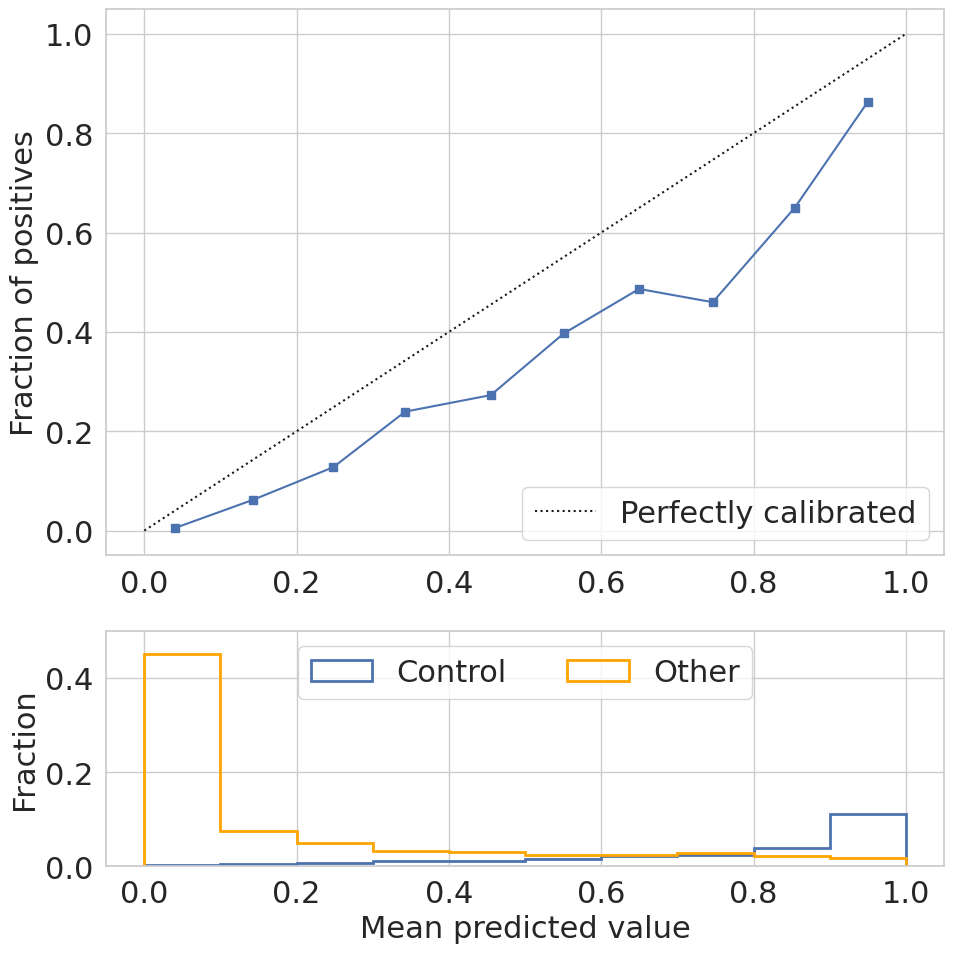

In [34]:
draw_calibration_curve(internal_meta, target, internal=True, target_label="Control")

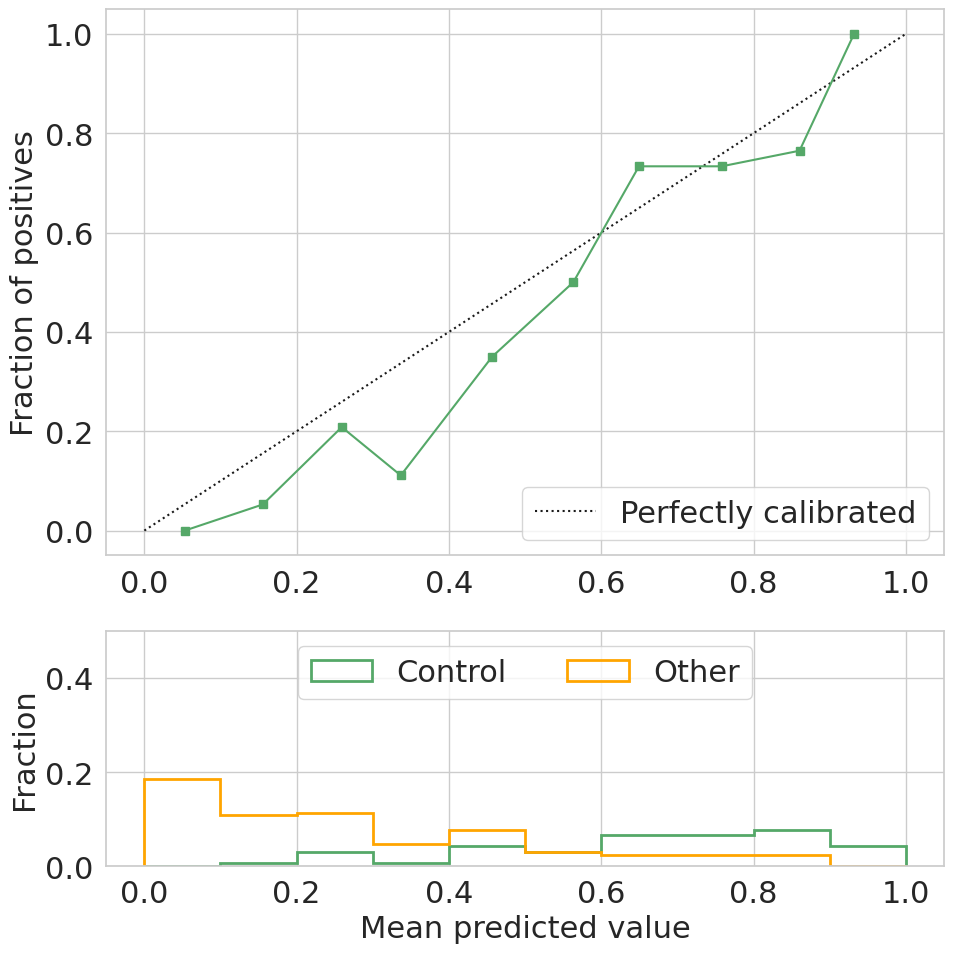

In [35]:
draw_calibration_curve(external_meta, target, internal=False, target_label="Control")

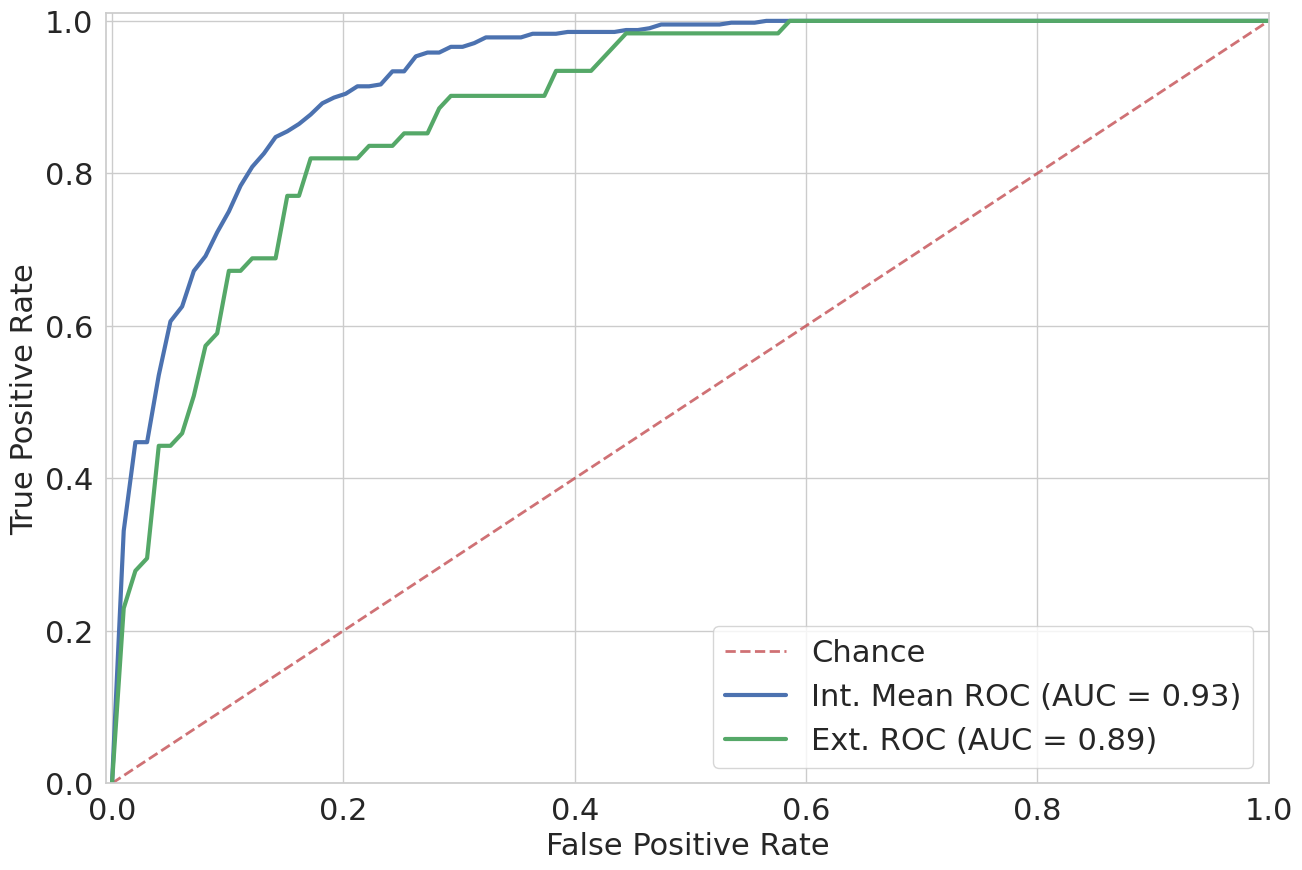

In [36]:
plot_roc_curve(internal_meta, external_meta, target)

## 1. Pneumonia

In [37]:
target = [1,2]

In [38]:
model = make_pipeline(LogisticRegression(random_state=0, class_weight="balanced", solver="liblinear"))
internal_meta, external_meta = experiment(model, target)

######################### FOLD 0-1 #########################

######################### FOLD 1-0 #########################

######################### FOLD 0-2 #########################

######################### FOLD 2-0 #########################

######################### FOLD 0-3 #########################

######################### FOLD 3-0 #########################

######################### FOLD 0-4 #########################

######################### FOLD 4-0 #########################

######################### FOLD 1-2 #########################

######################### FOLD 2-1 #########################

######################### FOLD 1-3 #########################

######################### FOLD 3-1 #########################

######################### FOLD 1-4 #########################

######################### FOLD 4-1 #########################

######################### FOLD 2-3 #########################

######################### FOLD 3-2 #########################

########

In [39]:
internal_statistics(internal_meta)

,Sensitivity (SD),Specificity (SD),AUROC (SD)
Internal,0.508 (0.197),0.858 (0.046),0.749 (0.097)


In [40]:
report_stats_reduced(internal_meta)

########## GVA & POA ##########
   Recall
0   0.872
1   0.508
2   0.802
3   0.922

Positive class recall: 0.508 %	Negative class recall: 0.858 %



,Recall
0,0.872
1,0.508
2,0.802
3,0.922


In [41]:
external_statistics(external_meta)

,Sensitivity (CI95),Specificity (CI95),AUROC (CI95)
External,0.469 (0.325-0.617),0.839 (0.760-0.900),0.739 (0.656-0.821)


In [42]:
report_stats_reduced(external_meta, internal=False)

########## GVA & POA ##########
   Recall
0   0.852
1   0.469
2   0.848
3   0.792

Positive class recall: 0.469 %	Negative class recall: 0.839 %



,Recall
0,0.852
1,0.469
2,0.848
3,0.792


In [36]:
#primary_stats(meta)

,Sensitivity,Specificity,AUROC
Internal,0.508 (0.414-0.603),0.858 (0.836-0.880),0.749 (0.702-0.795)
External,0.477 (0.444-0.509),0.806 (0.787-0.826),0.699 (0.690-0.707)
Diff,0.031,0.052,0.05


In [37]:
#report_recalls(cf_matrices)

,GVA,DKR,MAR,POA,RBA,YAO
Control,80.7% (n=71/88),86.6% (n=277/320),50.0% (n=20/40),89.1% (n=285/320),95.2% (n=571/600),61.9% (n=161/260)
Bact. Pneumonia,69.1% (n=47/68),14.0% (n=14/100),NaN (0/0),41.4% (n=53/128),NaN (0/0),51.7% (n=434/840)
Viral Pneumonia,56.2% (n=9/16),NaN (0/0),NaN (0/0),33.3% (n=8/24),NaN (0/0),47.5% (n=19/40)
Obst. Bronchitis,40.6% (n=26/64),NaN (0/0),NaN (0/0),82.5% (n=188/228),53.8% (n=43/80),40.8% (n=49/120)
Asthma,87.5% (n=154/176),96.9% (n=155/160),100.0% (n=20/20),91.2% (n=62/68),98.9% (n=277/280),NaN (0/0)
Bronchiolitis,91.7% (n=11/12),90.0% (n=18/20),60.6% (n=97/160),92.3% (n=336/364),NaN (0/0),71.7% (n=215/300)


In [38]:
#_ = report_stats(cf_matrices, meta)

########## GVA & POA ##########
                  Recall    N
Control            87.30  102
Bact. Pneumonia    51.00   49
Viral Pneumonia    42.50   10
Obst. Bronchitis   73.30   73
Asthma             88.50   61
Bronchiolitis      92.30   94
Micro (other)      85.35  330
Macro (other)      85.80  330

Positive class recall: 49.6 %	Negative class recall: 85.8 %

########## External validation data ##########
                  Recall    N
Control            84.30   61
Bact. Pneumonia    47.70   47
Viral Pneumonia    47.50    2
Obst. Bronchitis   46.00   10
Asthma             98.30   23
Bronchiolitis      68.80   24
Micro (other)      74.35  118
Macro (other)      80.60  118

Positive class recall: 47.7 %	Negative class recall: 80.6 %


In [39]:
_ = report_stats_reduced(cf_matrices, meta)

########## GVA & POA ##########
   Recall
0   0.872
1   0.508
2   0.802
3   0.922

Positive class recall: 0.508 %	Negative class recall: 0.858 %

########## External validation data ##########
   Recall
0   0.843
1   0.477
2   0.824
3   0.688

Positive class recall: 0.477 %	Negative class recall: 0.806 %


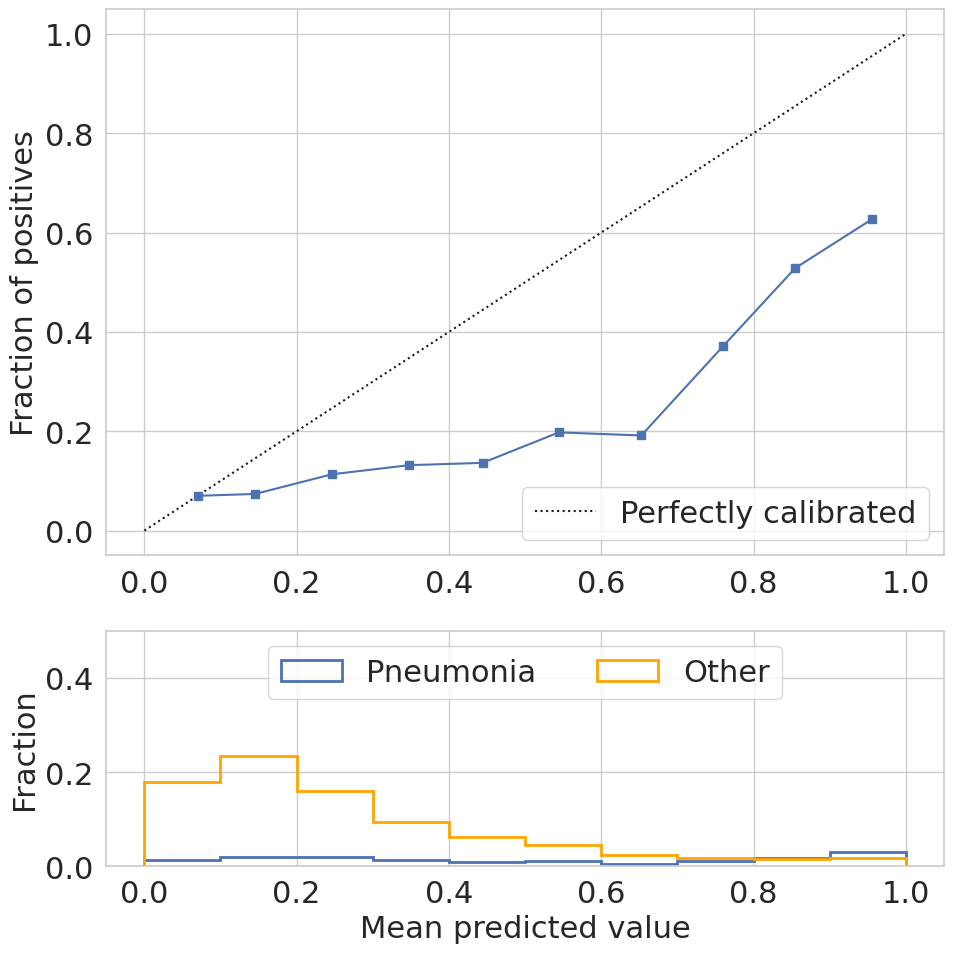

In [43]:
draw_calibration_curve(internal_meta, target, internal=True, target_label="Pneumonia")

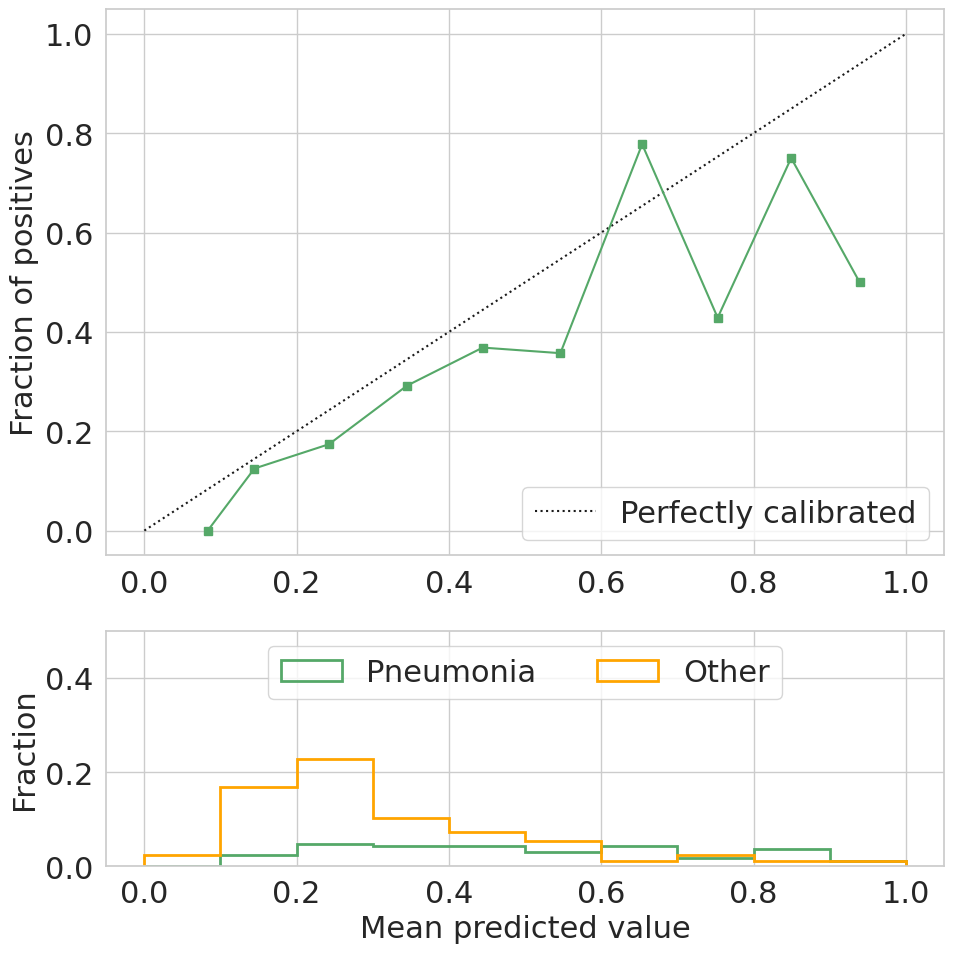

In [44]:
draw_calibration_curve(external_meta, target, internal=False, target_label="Pneumonia")

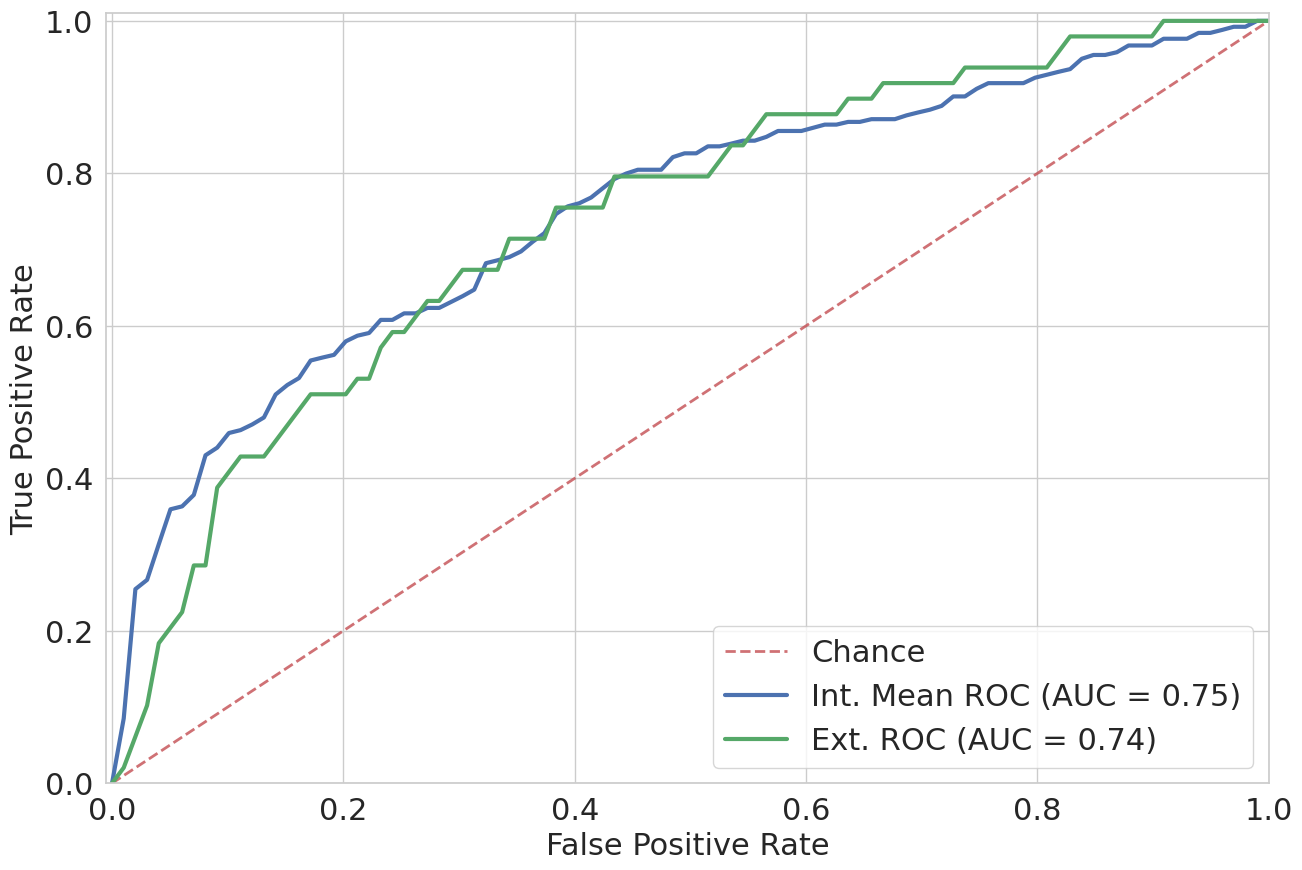

In [45]:
plot_roc_curve(internal_meta, external_meta, target)

## 2. Asthma & Obstructive Bronchitis

In [28]:
target = [3,4]

In [29]:
model = make_pipeline(LogisticRegression(random_state=0, class_weight="balanced", solver="liblinear"))
internal_meta, external_meta = experiment(model, target)

######################### FOLD 0-1 #########################

######################### FOLD 1-0 #########################

######################### FOLD 0-2 #########################

######################### FOLD 2-0 #########################

######################### FOLD 0-3 #########################

######################### FOLD 3-0 #########################

######################### FOLD 0-4 #########################

######################### FOLD 4-0 #########################

######################### FOLD 1-2 #########################

######################### FOLD 2-1 #########################

######################### FOLD 1-3 #########################

######################### FOLD 3-1 #########################

######################### FOLD 1-4 #########################

######################### FOLD 4-1 #########################

######################### FOLD 2-3 #########################

######################### FOLD 3-2 #########################

########

In [41]:
internal_statistics(internal_meta)

,Sensitivity (SD),Specificity (SD),AUROC (SD)
Internal,0.792 (0.088),0.880 (0.036),0.912 (0.033)


In [42]:
report_stats_reduced(internal_meta)

########## GVA & POA ##########
   Recall
0   0.959
1   0.712
2   0.792
3   0.899

Positive class recall: 0.792 %	Negative class recall: 0.88 %



,Recall
0,0.959
1,0.712
2,0.792
3,0.899


In [43]:
external_statistics(external_meta)

,Sensitivity (CI95),Specificity (CI95),AUROC (CI95)
External,0.636 (0.451-0.796),0.701 (0.616-0.777),0.743 (0.651-0.836)


In [30]:
external_statistics(external_meta)

21 33 0.6363636363636364
94 134 0.701


,Sensitivity (CI95),Specificity (CI95),AUROC (CI95)
External,0.636 (0.451-0.796),0.701 (0.616-0.777),0.743 (0.651-0.836)


In [44]:
report_stats_reduced(external_meta, internal=False)

########## GVA & POA ##########
   Recall
0   0.639
1   0.653
2   0.636
3   0.958

Positive class recall: 0.636 %	Negative class recall: 0.701 %



,Recall
0,0.639
1,0.653
2,0.636
3,0.958


In [45]:
primary_stats(meta)

,Sensitivity,Specificity,AUROC
Internal,0.764 (0.730-0.797),0.786 (0.761-0.810),0.848 (0.832-0.864)
External,0.711 (0.678-0.743),0.612 (0.575-0.649),0.735 (0.717-0.753)
Diff,0.053,0.174,0.113


In [32]:
# No validation fold
primary_stats(meta)

,Sensitivity,Specificity,AUROC
Internal,0.776 (0.746-0.806),0.799 (0.777-0.822),0.847 (0.832-0.863)
External,0.733 (0.701-0.766),0.610 (0.566-0.653),0.731 (0.711-0.751)
Diff,0.043,0.189,0.116


In [33]:
# Only val and test folds during training
primary_stats(meta)

,Sensitivity,Specificity,AUROC
Internal,0.901 (0.880-0.921),0.910 (0.895-0.925),0.970 (0.963-0.978)
External,0.755 (0.727-0.782),0.590 (0.542-0.639),0.731 (0.712-0.750)
Diff,0.146,0.32,0.239


In [46]:
report_recalls(cf_matrices)

,GVA,DKR,MAR,POA,RBA,YAO
Control,77.3% (n=68/88),48.1% (n=154/320),57.5% (n=23/40),96.9% (n=310/320),78.7% (n=472/600),66.9% (n=174/260)
Bact. Pneumonia,39.7% (n=27/68),67.0% (n=67/100),NaN (0/0),77.3% (n=99/128),NaN (0/0),49.0% (n=412/840)
Viral Pneumonia,37.5% (n=6/16),NaN (0/0),NaN (0/0),62.5% (n=15/24),NaN (0/0),22.5% (n=9/40)
Obst. Bronchitis,76.6% (n=49/64),NaN (0/0),NaN (0/0),64.9% (n=148/228),31.2% (n=25/80),36.7% (n=44/120)
Asthma,93.2% (n=164/176),96.9% (n=155/160),100.0% (n=20/20),70.6% (n=48/68),80.4% (n=225/280),NaN (0/0)
Bronchiolitis,16.7% (n=2/12),20.0% (n=4/20),93.8% (n=150/160),75.0% (n=273/364),NaN (0/0),58.3% (n=175/300)


In [51]:
_ = report_stats(cf_matrices, meta)

########## GVA & POA ##########
                  Recall    N
Control           96.300  102
Bact. Pneumonia   73.000   49
Viral Pneumonia   62.500   10
Obst. Bronchitis  67.500   20
Asthma            84.400   61
Bronchiolitis     90.700   94
Micro (other)     80.625  255
Macro (other)     88.400  255

Positive class recall: 80.2 %	Negative class recall: 88.4 %

########## External validation data ##########
                  Recall    N
Control           65.200   61
Bact. Pneumonia   66.000   47
Viral Pneumonia   32.500    2
Obst. Bronchitis  25.000   10
Asthma            76.300   23
Bronchiolitis     90.800   24
Micro (other)     63.625  134
Macro (other)     69.600  134

Positive class recall: 60.8 %	Negative class recall: 69.6 %


In [47]:
_ = report_stats(cf_matrices, meta)

########## GVA & POA ##########
                  Recall    N
Control           92.600  102
Bact. Pneumonia   64.300   49
Viral Pneumonia   52.500   10
Obst. Bronchitis  67.500   73
Asthma            86.900   61
Bronchiolitis     73.100   94
Micro (other)     70.625  255
Macro (other)     78.400  255

Positive class recall: 76.3 %	Negative class recall: 78.4 %

########## External validation data ##########
                  Recall    N
Control           67.500   61
Bact. Pneumonia   51.000   47
Viral Pneumonia   22.500    2
Obst. Bronchitis  34.500   10
Asthma            87.000   23
Bronchiolitis     68.500   24
Micro (other)     52.375  134
Macro (other)     61.200  134

Positive class recall: 71.1 %	Negative class recall: 61.2 %


In [48]:
_ = report_stats_reduced(cf_matrices, meta)

########## GVA & POA ##########
   Recall
0   0.927
1   0.629
2   0.764
3   0.731

Positive class recall: 0.764 %	Negative class recall: 0.786 %

########## External validation data ##########
   Recall
0   0.675
1   0.498
2   0.711
3   0.685

Positive class recall: 0.711 %	Negative class recall: 0.612 %


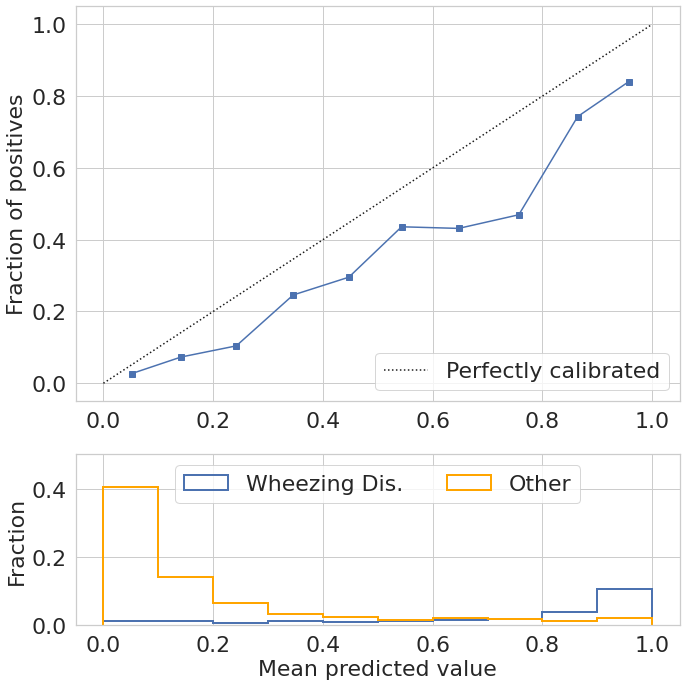

In [ ]:
draw_calibration_curve(internal_meta, target, internal=True, target_label="Wheezing Dis.")

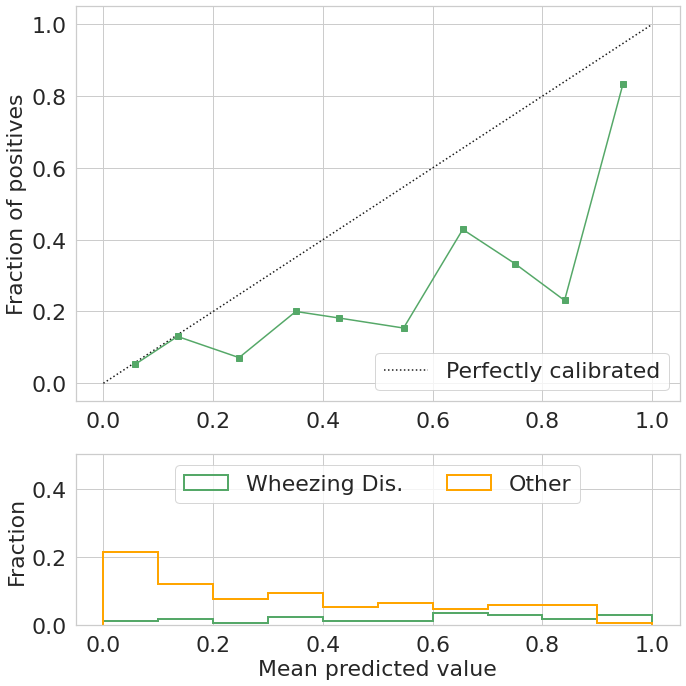

In [46]:
draw_calibration_curve(external_meta, target, internal=False, target_label="Wheezing Dis.")

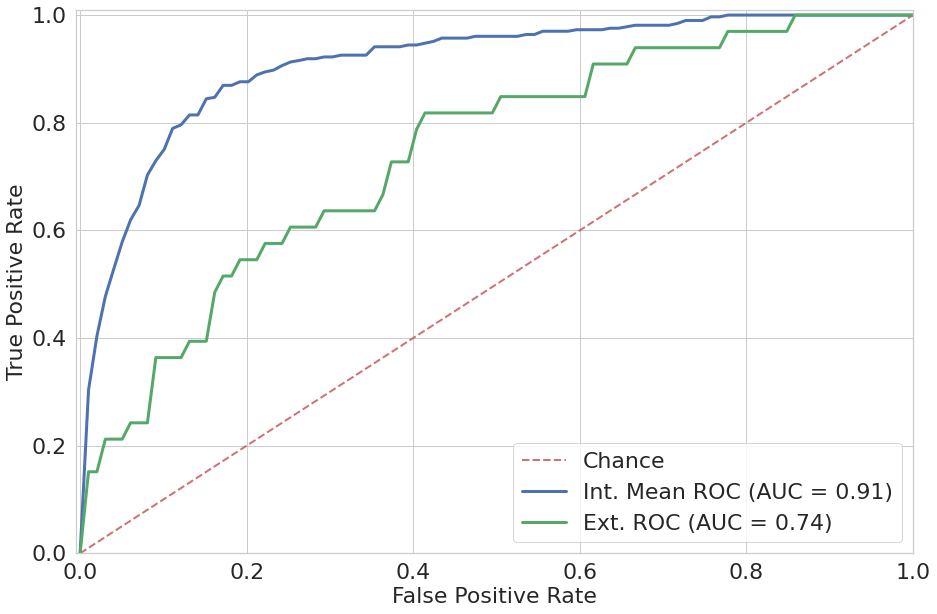

In [44]:
plot_roc_curve(internal_meta, external_meta, target)

## 3. Bronchiolitis

In [45]:
target = [5]

In [46]:
model = make_pipeline(LogisticRegression(random_state=0, class_weight="balanced", solver="liblinear"))
internal_meta, external_meta = experiment(model, target)

######################### FOLD 0-1 #########################

######################### FOLD 1-0 #########################

######################### FOLD 0-2 #########################

######################### FOLD 2-0 #########################

######################### FOLD 0-3 #########################

######################### FOLD 3-0 #########################

######################### FOLD 0-4 #########################

######################### FOLD 4-0 #########################

######################### FOLD 1-2 #########################

######################### FOLD 2-1 #########################

######################### FOLD 1-3 #########################

######################### FOLD 3-1 #########################

######################### FOLD 1-4 #########################

######################### FOLD 4-1 #########################

######################### FOLD 2-3 #########################

######################### FOLD 3-2 #########################

########

In [47]:
internal_statistics(internal_meta)

,Sensitivity (SD),Specificity (SD),AUROC (SD)
Internal,0.830 (0.077),0.880 (0.044),0.939 (0.021)


In [48]:
report_stats_reduced(internal_meta)

########## GVA & POA ##########
   Recall
0   0.890
1   0.820
2   0.916
3   0.830

Positive class recall: 0.83 %	Negative class recall: 0.88 %



,Recall
0,0.890
1,0.820
2,0.916
3,0.830


In [49]:
external_statistics(external_meta)

,Sensitivity (CI95),Specificity (CI95),AUROC (CI95)
External,0.500 (0.291-0.709),0.923 (0.867-0.961),0.870 (0.796-0.943)


In [50]:
report_stats_reduced(external_meta, internal=False)

########## GVA & POA ##########
   Recall
0   0.984
1   0.857
2   0.909
3   0.500

Positive class recall: 0.5 %	Negative class recall: 0.923 %



,Recall
0,0.984
1,0.857
2,0.909
3,0.500


In [54]:
primary_stats(meta)

,Sensitivity,Specificity,AUROC
Internal,0.766 (0.727-0.806),0.844 (0.822-0.867),0.907 (0.894-0.920)
External,0.379 (0.352-0.407),0.952 (0.946-0.958),0.830 (0.820-0.840)
Diff,0.387,-0.108,0.077


In [35]:
# No validation folds
primary_stats(meta)

,Sensitivity,Specificity,AUROC
Internal,0.737 (0.700-0.774),0.861 (0.836-0.886),0.908 (0.895-0.921)
External,0.360 (0.322-0.399),0.957 (0.950-0.963),0.840 (0.832-0.849)
Diff,0.377,-0.096,0.068


In [55]:
report_recalls(cf_matrices)

,GVA,DKR,MAR,POA,RBA,YAO
Control,95.5% (n=84/88),100.0% (n=320/320),100.0% (n=40/40),87.2% (n=279/320),96.5% (n=579/600),100.0% (n=260/260)
Bact. Pneumonia,98.5% (n=67/68),100.0% (n=100/100),NaN (0/0),85.2% (n=109/128),NaN (0/0),89.0% (n=748/840)
Viral Pneumonia,100.0% (n=16/16),NaN (0/0),NaN (0/0),50.0% (n=12/24),NaN (0/0),100.0% (n=40/40)
Obst. Bronchitis,84.4% (n=54/64),NaN (0/0),NaN (0/0),59.6% (n=136/228),100.0% (n=80/80),100.0% (n=120/120)
Asthma,100.0% (n=176/176),100.0% (n=160/160),100.0% (n=20/20),91.2% (n=62/68),91.4% (n=256/280),NaN (0/0)
Bronchiolitis,33.3% (n=4/12),0.0% (n=0/20),28.8% (n=46/160),78.3% (n=285/364),NaN (0/0),45.3% (n=136/300)


In [56]:
_ = report_stats(cf_matrices, meta)

########## GVA & POA ##########
                  Recall    N
Control            89.00  102
Bact. Pneumonia    89.80   49
Viral Pneumonia    70.00   10
Obst. Bronchitis   65.10   73
Asthma             97.50   61
Bronchiolitis      76.90   94
Micro (other)      82.28  295
Macro (other)      84.30  295

Positive class recall: 76.9 %	Negative class recall: 84.3 %

########## External validation data ##########
                  Recall    N
Control            98.30   61
Bact. Pneumonia    90.20   47
Viral Pneumonia   100.00    2
Obst. Bronchitis  100.00   10
Asthma             94.80   23
Bronchiolitis      37.90   24
Micro (other)      96.66  143
Macro (other)      95.20  143

Positive class recall: 37.9 %	Negative class recall: 95.2 %


In [57]:
_ = report_stats_reduced(cf_matrices, meta)

########## GVA & POA ##########
   Recall
0   0.890
1   0.874
2   0.800
3   0.766

Positive class recall: 0.766 %	Negative class recall: 0.844 %

########## External validation data ##########
   Recall
0   0.983
1   0.906
2   0.964
3   0.379

Positive class recall: 0.379 %	Negative class recall: 0.952 %


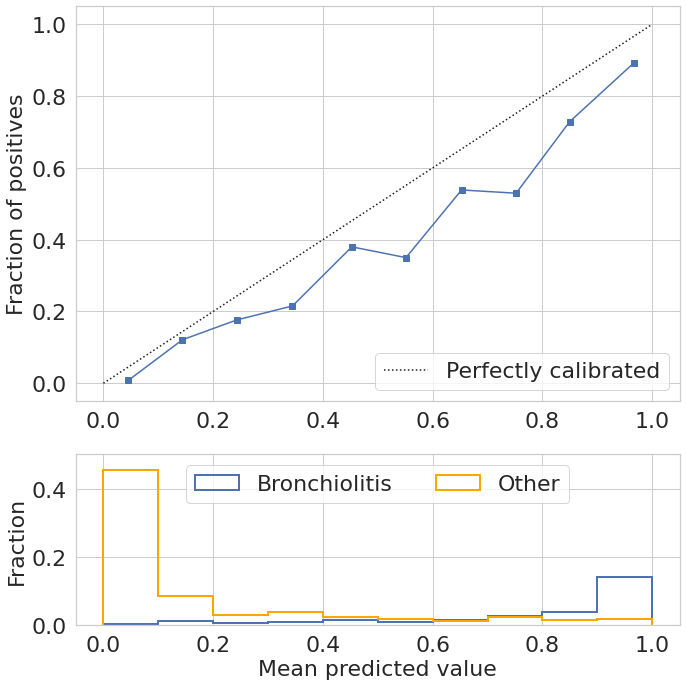

In [52]:
draw_calibration_curve(internal_meta, target, internal=True, target_label="Bronchiolitis")

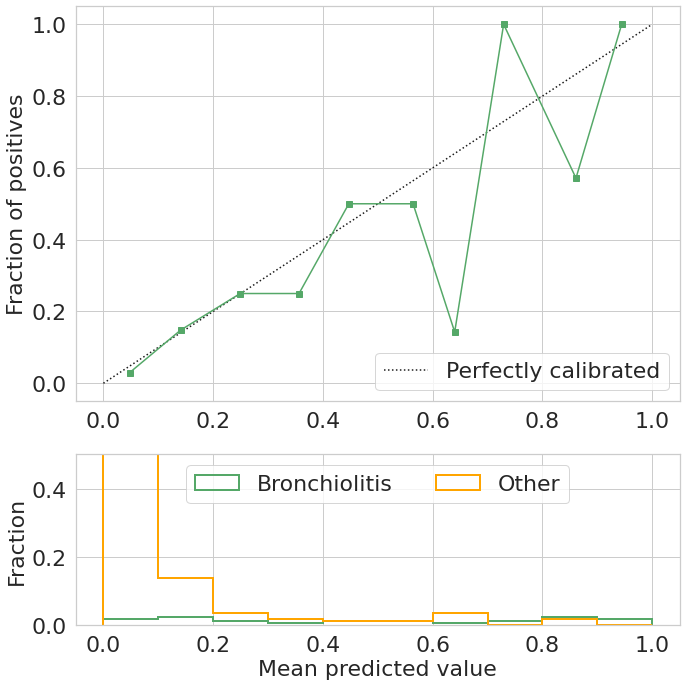

In [53]:
draw_calibration_curve(external_meta, target, internal=False, target_label="Bronchiolitis")

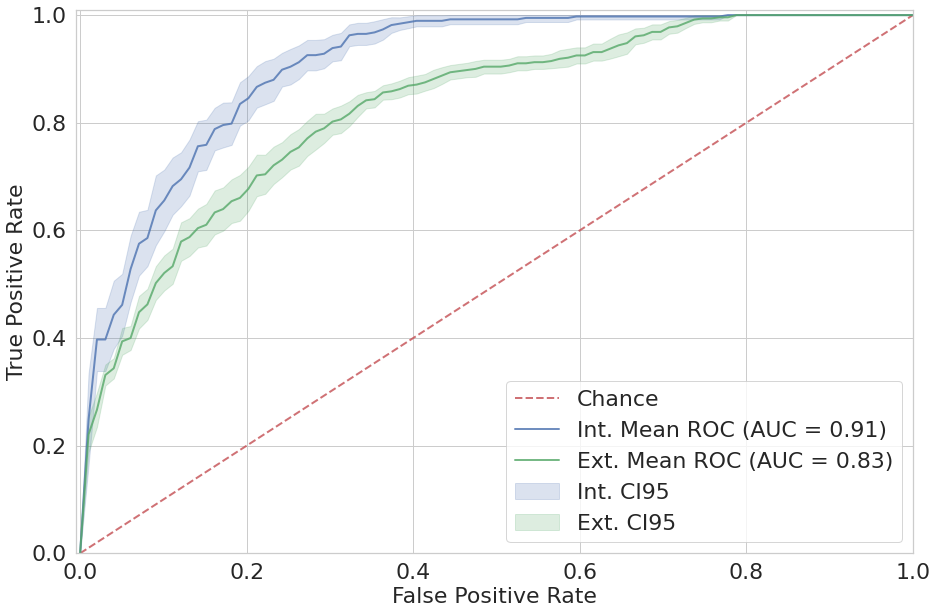

In [60]:
plot_roc_curve(meta, target)

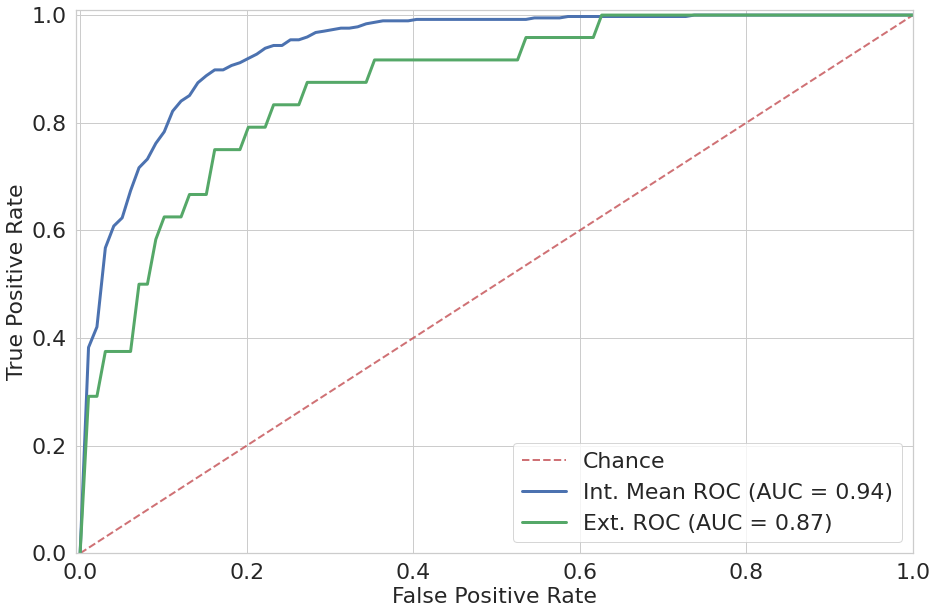

In [50]:
plot_roc_curve(internal_meta, external_meta, target)